# CMIP6 ECS Calculation from Pangeo Gallery

In [2]:
import cartopy
import dask
import fsspec
import intake
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
from distributed import Client
from matplotlib import pyplot as plt
from ncar_jobqueue import NCARCluster
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'

In [3]:
cluster = NCARCluster()
cluster.scale(20)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mgrover/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mgrover/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.50:37934,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mgrover/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
from intake_esm.derived import DerivedVariableRegistry

## Define some Derived Variables

In [5]:
dvr = DerivedVariableRegistry()

In [6]:
@dvr.register(variable='imbalance', query={'variable_id': ['rsdt', 'rsut', 'rlut']})
def imbalance(ds):
    ds['imbalance'] = ds.rsdt - ds.rsut - ds.rlut
    ds['imbalance'].attrs['long_name'] = 'Global Mean Radiative Imbalance'
    ds['imbalance'].attrs['units'] = 'W m$^{-2}$'
    return ds

In [7]:
data_catalog = intake.open_esm_datastore(
    "https://storage.googleapis.com/cmip6/pangeo-cmip6.json",
    registry=dvr,
)

In [8]:
query = dict(
    experiment_id=[
        'abrupt-4xCO2',
        'piControl',
    ],  # pick the `abrupt-4xCO2` and `piControl` forcing experiments
    table_id='Amon',  # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
    variable_id=[
        'tas',
        'rsut',
        'rsdt',
        'rlut',
    ],  # choose to look at near-surface air temperature (tas) as our variable
    member_id='r1i1p1f1',
    source_id='ACCESS-CM2',  # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)
)
col_subset = data_catalog.search(**query)
col_subset.df.groupby("source_id")['member_id'].unique()
col_subset.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CSIRO-ARCCSS,ACCESS-CM2,abrupt-4xCO2,r1i1p1f1,Amon,rlut,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191108
1,CMIP,CSIRO-ARCCSS,ACCESS-CM2,abrupt-4xCO2,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191108
2,CMIP,CSIRO-ARCCSS,ACCESS-CM2,abrupt-4xCO2,r1i1p1f1,Amon,rsdt,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191108
3,CMIP,CSIRO-ARCCSS,ACCESS-CM2,abrupt-4xCO2,r1i1p1f1,Amon,rsut,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191108
4,CMIP,CSIRO-ARCCSS,ACCESS-CM2,piControl,r1i1p1f1,Amon,rlut,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191112
5,CMIP,CSIRO-ARCCSS,ACCESS-CM2,piControl,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191112
6,CMIP,CSIRO-ARCCSS,ACCESS-CM2,piControl,r1i1p1f1,Amon,rsut,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191112
7,CMIP,CSIRO-ARCCSS,ACCESS-CM2,piControl,r1i1p1f1,Amon,rsdt,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191112


## Define Operators

In [56]:
def get_lat_name(ds):
    """Figure out what is the latitude coordinate for each dataset."""
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")


def global_mean(ds):
    """Return global mean of a whole dataset."""
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)


def yearly_mean(ds):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out


def imbalance(ds):
    ds['imbalance'] = ds.rsdt - ds.rsut - ds.rlut
    ds['imbalance'].attrs['long_name'] = 'Global Mean Radiative Imbalance'
    ds['imbalance'].attrs['units'] = 'W m$^{-2}$'
    return ds

In [13]:
collection = col_subset.to_collection(storage_options={'anon': True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/glade/work/mgrover/miniconda3/envs/esds-funnel-docs/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/mgrover/miniconda3/envs/esds-funnel-docs/lib/python3.9/site-packages/xarray/coding/times.py:119: SerializationWarning: Ambiguous reference date string: 950-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0950-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/glade/work/mgrover/miniconda3/envs/esds-funnel-docs/lib/python3.9/site-packages/xarray/core/indexing.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetim

In [83]:
print(collection)

<Collection (2 keys)>
🔑 CMIP.CSIRO-ARCCSS.ACCESS-CM2.piControl.Amon.gn
<xarray.Dataset>
Dimensions:         (lat: 144, bnds: 2, lon: 192, member_id: 1, dcpp_init_year: 1, time: 6000)
Coordinates:
  * lat             (lat) float64 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
    lat_bnds        (lat, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * lon             (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    lon_bnds        (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time            (time) object 0950-01-16 12:00:00 ... 1449-12-16 12:00:00
    time_bnds       (time, bnds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
  * member_id       (member_id) <U8 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    height          float64 ...
Dimensions without coordinates: bnds
Data variables:
    rlut            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 539, 144, 192), meta=n

In [88]:
pi_control = collection['CMIP.CSIRO-ARCCSS.ACCESS-CM2.piControl.Amon.gn']

In [89]:
anom_collection = collection
for key in anom_collection.keys():
    anom_collection[key] = anom_collection[key] - pi_control.mean(dim='time')

In [43]:
ds = collection['CMIP.CSIRO-ARCCSS.ACCESS-CM2.piControl.Amon.gn']
ds

<xarray.Dataset>
Dimensions:         (lat: 144, bnds: 2, lon: 192, member_id: 1, dcpp_init_year: 1, time: 6000)
Coordinates:
  * lat             (lat) float64 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
    lat_bnds        (lat, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * lon             (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    lon_bnds        (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time            (time) object 0950-01-16 12:00:00 ... 1449-12-16 12:00:00
    time_bnds       (time, bnds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
  * member_id       (member_id) <U8 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    height          float64 ...
Dimensions without coordinates: bnds
Data variables:
    rlut            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 539, 144, 192), meta=np.ndarray>
    rsdt            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 3000, 144, 192), meta=np.ndarray>
    rsut            (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 554, 144, 192), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, lat, lon) float32 dask.array<chunksize=(1, 1, 668, 144, 192), meta=np.ndarray>
Attributes: (12/54)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            346615.0
    cmor_version:                     3.4.0
    ...                               ...
    intake_esm_attrs/member_id:       r1i1p1f1
    intake_esm_attrs/table_id:        Amon
    intake_esm_attrs/grid_label:      gn
    intake_esm_attrs/dcpp_init_year:  nan
    intake_esm_attrs/version:         20191112
    intake_esm_dataset_key:           CMIP.CSIRO-ARCCSS.ACCESS-CM2.piControl....

In [92]:
ecs_collection = collection.map(yearly_mean).map(global_mean).map(imbalance)
ecs_collection_anom = anom_collection.map(yearly_mean).map(global_mean).map(imbalance)

In [93]:
print(ecs_collection)
print(ecs_collection_anom)

<Collection (2 keys)>
🔑 CMIP.CSIRO-ARCCSS.ACCESS-CM2.piControl.Amon.gn
<xarray.Dataset>
Dimensions:    (time: 500)
Coordinates:
  * time       (time) object 0950-01-01 00:00:00 ... 1449-01-01 00:00:00
    height     float64 2.0
Data variables:
    rlut       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rsdt       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rsut       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    tas        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    imbalance  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

🔑 CMIP.CSIRO-ARCCSS.ACCESS-CM2.abrupt-4xCO2.Amon.gn
<xarray.Dataset>
Dimensions:    (time: 150)
Coordinates:
  * time       (time) object 0950-01-01 00:00:00 ... 1099-01-01 00:00:00
    height     float64 2.0
Data variables:
    rlut       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rsdt       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rsut    

## Plot the Fields

We start by subsetting for the first 150 years

In [94]:
first_150_years = slice(0, 149)

In [95]:
def plot_field(ds, field, time_subset=first_150_years):
    return ds.isel(time=time_subset)[field].plot()

In [96]:
ecs_collection.keys()

dict_keys(['CMIP.CSIRO-ARCCSS.ACCESS-CM2.piControl.Amon.gn', 'CMIP.CSIRO-ARCCSS.ACCESS-CM2.abrupt-4xCO2.Amon.gn'])

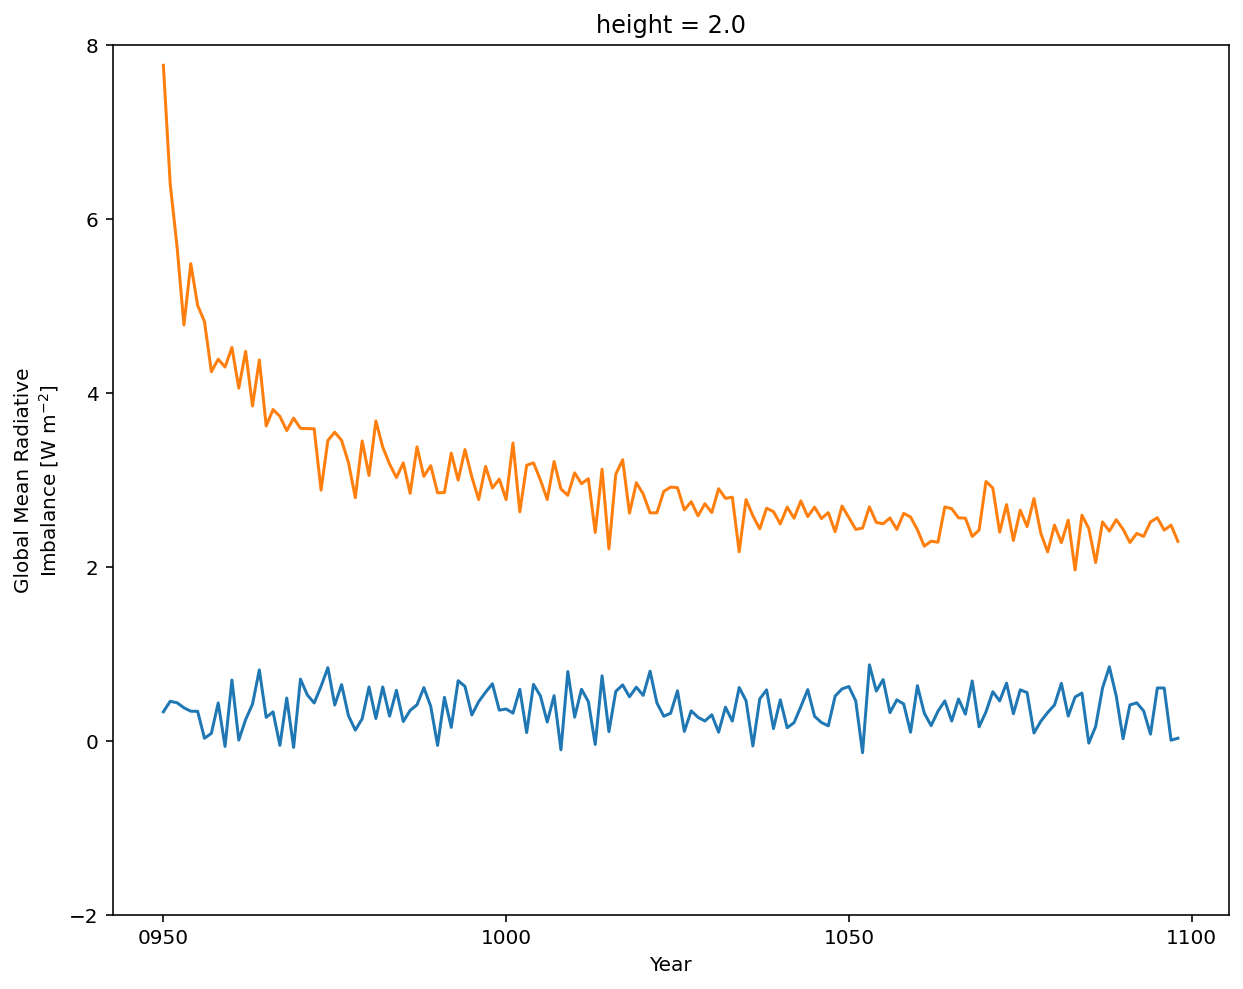

In [71]:
fig = plt.figure(figsize=(10, 8))
for key in ecs_collection.keys():
    plot_field(ecs_collection[key], 'imbalance')

plt.ylim(-2, 8)
plt.xlabel('Year')
plt.show()

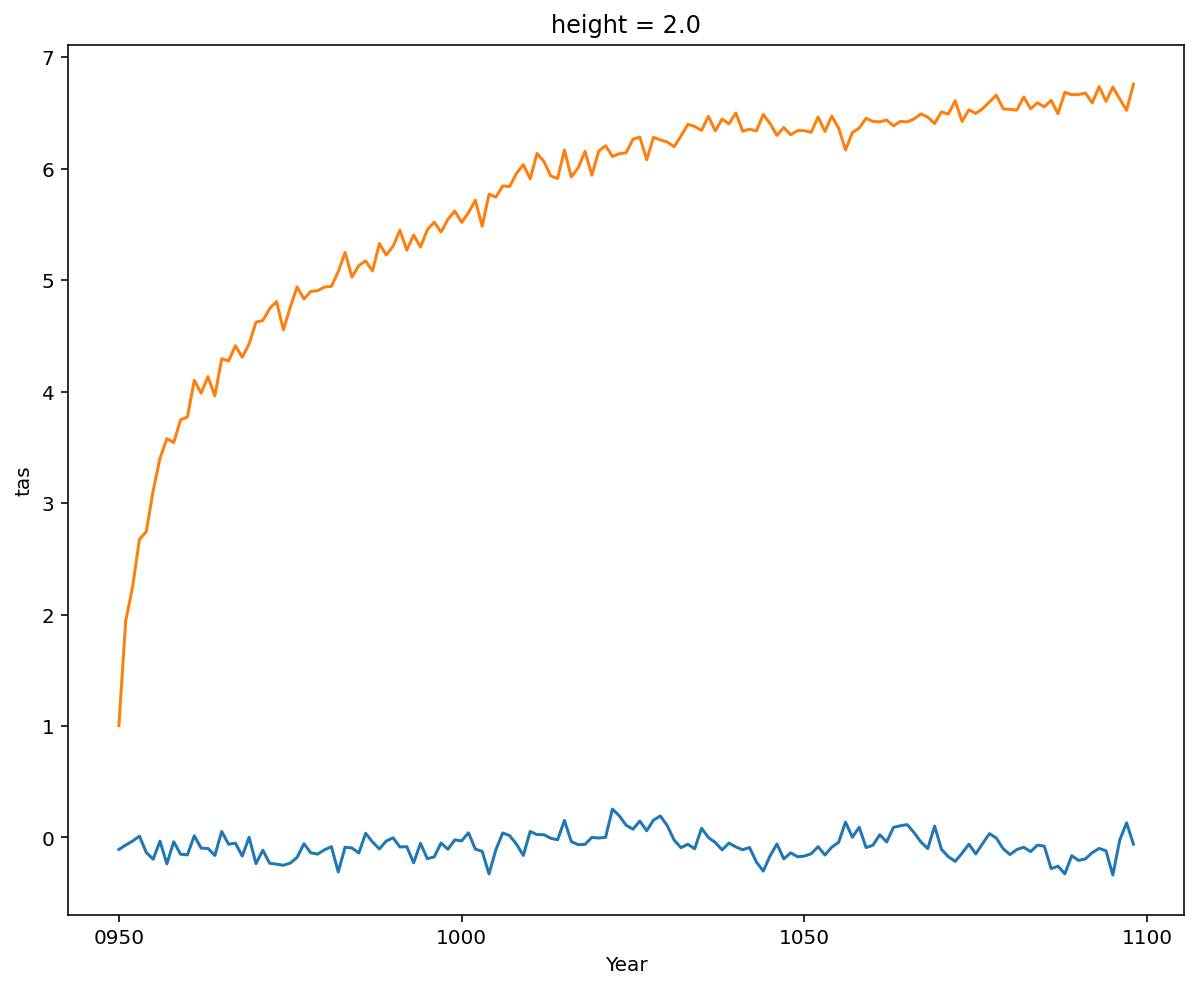

In [97]:
fig = plt.figure(figsize=(10, 8))
for key in ecs_collection_anom.keys():
    plot_field(ecs_collection_anom[key], 'tas')

plt.xlabel('Year')
plt.show()

In [98]:
def calc_ecs(ds):
    ds = ds.isel(time=first_150_years)

    # Some sources don't have all 150 years, drop those missing values.
    a, b = np.polyfit(ds.tas.dropna("time"), ds.imbalance.dropna("time"), 1)
    ecs = -0.5 * (b / a)
    return xr.DataArray(ecs)

In [100]:
ecs = calc_ecs(
    ecs_collection_anom['CMIP.CSIRO-ARCCSS.ACCESS-CM2.abrupt-4xCO2.Amon.gn'].isel(
        time=first_150_years
    )
)

In [102]:
ecs

<xarray.DataArray ()>
array(4.68304544)